In [1]:
import os
sys.path.append("../")
import sys
from utilities.gcn_utills import *
import torch
import pickle
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import networkx as nx
import glob
import pandas as pd
import scipy 
import torch
import torch.nn.functional as F
from tqdm import tqdm
from torch_geometric.utils import convert
from torch_geometric.data import InMemoryDataset, download_url, Data
from torch_geometric.loader import DataLoader
from torch.nn import Linear
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool, global_max_pool

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score


In [2]:
# Load in label by name
def get_label(file, labels):
    pair_1 = file.split('/')[-1]
    pair_1, pair_2 = pair_1.split("and")
    pair_1 = pair_1.replace(".gpickle", "")
    pair_2 = pair_2.replace(".gpickle", "")
    l = int(labels.loc[(labels.protein_1 == pair_1) & (labels.protein_2 == pair_2)].label)
    return file, l

def read_graphs(file_set):
    g_list = []
    for i, file in enumerate(file_set):
        G = nx.read_gpickle(file)
        g_list.append(G)
    return g_list
    
def format_graphs(graphs, label=1):
    graph_list = []
    # Convert into pytorch geoetric dataset: Positive
    for i, x in enumerate(tqdm(graphs)):
        F = nx.convert_node_labels_to_integers(x)
        for (n1, n2, d) in F.edges(data=True):
            d.clear()
        data = convert.from_networkx(F, group_edge_attrs=None)
        data.y = torch.FloatTensor(np.array([label]))
        graph_list.append(data)
    return graph_list

def binary_acc(y_pred, y_test):
    probas = torch.sigmoid(y_pred)
    y_pred_tag = torch.round(torch.sigmoid(y_pred))
    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    return acc, y_pred_tag, probas

In [3]:
# Import the data
graph_dir_path = '/mnt/mnemo5/sum02dean/sl_projects/GCN/GCN-STRING/src/scripts/graph_data'
labels_dir_path = '/mnt/mnemo5/sum02dean/sl_projects/GCN/GCN-STRING/src/scripts/graph_labels'

graph_files = glob.glob(os.path.join(graph_dir_path, '*'))
graph_labels = glob.glob(os.path.join(labels_dir_path, '*'))
graph_labels = pd.read_csv(graph_labels[0])

# Create positive and negative sets
positives = []
pos_labels = []

negatives = []
neg_labels = []

for i, file in enumerate(graph_files):
    obs, label = get_label(file, graph_labels)
    
    if label == 1:
        positives.append(obs)
        pos_labels.append([1,0])
    else:
        negatives.append(obs)
        neg_labels.append([0,1])


KeyboardInterrupt: 

In [ ]:
# Balance the number of negatives with number of positives
negatives = np.random.choice(negatives, size=len(positives), replace=False)

In [ ]:
# Read in the positives
pos_graphs = read_graphs(positives)
neg_graphs = read_graphs(negatives)


In [ ]:
# Format graphs
positive_graphs = format_graphs(pos_graphs, label=1)
negative_graphs = format_graphs(neg_graphs, label=0)

  0%|          | 0/5456 [00:00<?, ?it/s]/mnt/mnemo5/sum02dean/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch_geometric/utils/convert.py:170: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272068185/work/torch/csrc/utils/tensor_new.cpp:201.)
  data[key] = torch.tensor(value)
100%|██████████| 5456/5456 [07:17<00:00, 12.48it/s]  


In [9]:
# Make sure number of negative graphs equal number of positives graphs
assert (len(negative_graphs) == len(positive_graphs))

In [11]:
from sklearn.preprocessing import MinMaxScaler
# Combine negative and positive data
balanced_graphs = positive_graphs + negative_graphs

ss = MinMaxScaler()
train_x = np.vstack([d.x for d in balanced_graphs])
train_x = pd.DataFrame(train_x)

display(train_x.head())
train_x = pd.DataFrame(ss.fit_transform(train_x))
display(train_x.head())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.814468,162.975100,0.000330,0.000048,0.999621,0.000046,0.000157,2.072345e-07,0.000056,0.000016,0.000475,0.000548,0.998702,-87.686188,140.659607,0.806728
1,0.643585,75.428109,0.016258,0.002547,0.981195,0.002067,0.007617,1.779546e-05,0.001422,0.001080,0.006447,0.005204,0.976143,-85.763329,140.484634,0.348744
2,0.434347,104.460469,0.369673,0.001916,0.628411,0.101635,0.312523,2.422128e-03,0.000849,0.001450,0.051687,0.162337,0.367096,-68.709030,-30.898502,0.237885
3,0.351372,65.003843,0.453501,0.009811,0.536688,0.138164,0.309665,3.592184e-03,0.004173,0.007392,0.051421,0.150600,0.334994,-73.034126,-24.023359,0.270601
4,0.622860,108.813592,0.594857,0.014759,0.390384,0.133626,0.448714,2.794695e-03,0.002449,0.015687,0.044883,0.100467,0.251379,-73.304596,-29.837749,0.114553


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.838683,0.745196,0.000330,0.000048,0.999622,0.000047,0.000157,2.076412e-07,0.000059,0.000016,0.000482,0.000548,0.998703,0.256448,0.890725,0.806728
1,0.662657,0.344814,0.016258,0.002547,0.981195,0.002073,0.007619,1.783045e-05,0.001479,0.001080,0.006554,0.005212,0.976144,0.261790,0.890239,0.348744
2,0.447122,0.477589,0.369683,0.001916,0.628408,0.101911,0.312572,2.426890e-03,0.000883,0.001450,0.052543,0.162573,0.367097,0.309168,0.414153,0.237885
3,0.361650,0.297140,0.453512,0.009811,0.536685,0.138539,0.309713,3.599247e-03,0.004339,0.007392,0.052272,0.150819,0.334994,0.297153,0.433251,0.270601
4,0.641308,0.497497,0.594872,0.014759,0.390380,0.133989,0.448784,2.800190e-03,0.002547,0.015687,0.045627,0.100613,0.251380,0.296401,0.417099,0.114553


In [12]:
for i in range(len(balanced_graphs)):
    balanced_graphs[i].x = torch.FloatTensor(ss.transform(balanced_graphs[i].x))


tensor([[8.3868e-01, 7.4520e-01, 3.3039e-04,  ..., 2.5645e-01, 8.9072e-01,
         8.0673e-01],
        [6.6266e-01, 3.4481e-01, 1.6258e-02,  ..., 2.6179e-01, 8.9024e-01,
         3.4874e-01],
        [4.4712e-01, 4.7759e-01, 3.6968e-01,  ..., 3.0917e-01, 4.1415e-01,
         2.3789e-01],
        ...,
        [6.8865e-01, 6.2904e-01, 6.1145e-03,  ..., 2.3445e-01, 8.7019e-01,
         4.2524e-01],
        [7.5714e-01, 4.7704e-01, 2.3886e-03,  ..., 3.1186e-01, 8.9342e-01,
         3.3632e-01],
        [8.5304e-01, 8.6744e-01, 1.5776e-04,  ..., 2.3153e-01, 8.7039e-01,
         5.3027e-01]])

In [13]:
# Split into train and test
train_idx = np.random.choice(a=[False, True], size=len(balanced_graphs))
test_idx = ~train_idx

# Convert range to array 
full_idx = np.array(range(len(balanced_graphs)))

# Grab indices using Boolean array
tr_idx = full_idx[train_idx]
te_idx = full_idx[test_idx]

# Slice train and test data
train_data = [balanced_graphs[x] for x in tr_idx]
test_data = [balanced_graphs[x] for x in te_idx]



In [14]:
# Select appropriate device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Define model
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels=64):
        super(GCN, self).__init__()

        # Parameters
        self.num_node_features = 16
        self.num_classes = 1
        self.hidden_channels = hidden_channels

        # Layers (consider using class SAGEConv instead)
        self.conv1 = GCNConv(self.num_node_features, self.hidden_channels)
        self.linear_1 = Linear(self.hidden_channels, self.hidden_channels)
        self.linear_2 = Linear(self.hidden_channels, self.num_classes)

        # Paramteric PRelU
        self.prelu_1 = torch.nn.PReLU()
        self.prelu_2 = torch.nn.PReLU()
        self.prelu_3 = torch.nn.PReLU()

        # Regularization
        p = 0.5
        self.drop_out = torch.nn.Dropout(p=p)

        # Batch Normalization
        self.batch_norm_1 = torch.nn.BatchNorm1d(num_features=self.hidden_channels, track_running_stats=False, momentum=None)
        self.batch_norm_2 = torch.nn.BatchNorm1d(num_features=self.hidden_channels, track_running_stats=False, momentum=None)
        self.batch_norm_3 = torch.nn.BatchNorm1d(num_features=self.num_classes, track_running_stats=False, momentum=None)

    def forward(self, x, edge_index, batch):

        # 1.Conv block 1
        x = self.conv1(x, edge_index)
        x = self.prelu_1(x)
        
        # Feature pooling
        x = global_max_pool(x, batch)  # --> [batch_size, hidden_channels]

        # 3. Linearization
        x = self.linear_1(x)
        x = self.batch_norm_2(x)
        x = self.prelu_2(x)

        # 4. Logic outputs
        x = self.linear_2(x)
        x = self.batch_norm_3(x)
        x = self.drop_out(x)
        x = self.prelu_2(x)
        return x


cpu


In [16]:
# Build model
model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(16, 16)
  (linear_1): Linear(in_features=16, out_features=16, bias=True)
  (linear_2): Linear(in_features=16, out_features=1, bias=True)
  (prelu_1): PReLU(num_parameters=1)
  (prelu_2): PReLU(num_parameters=1)
  (prelu_3): PReLU(num_parameters=1)
  (drop_out): Dropout(p=0.5, inplace=False)
  (batch_norm_1): BatchNorm1d(16, eps=1e-05, momentum=None, affine=True, track_running_stats=False)
  (batch_norm_2): BatchNorm1d(16, eps=1e-05, momentum=None, affine=True, track_running_stats=False)
  (batch_norm_3): BatchNorm1d(1, eps=1e-05, momentum=None, affine=True, track_running_stats=False)
)


In [17]:
# Configs
BATCH_SIZE = 50
EPOCHS = 50
LEARNING_RATE = 0.002

# Optimizers & Criterion
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = torch.nn.BCEWithLogitsLoss()

# Data-loaders
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)
all_loader  = DataLoader(balanced_graphs, batch_size=BATCH_SIZE, shuffle=False)


In [19]:
# Train loop
print("Begining training!")
model.train()
model = model.float()

for epoch in range(EPOCHS):
    epoch_loss = 0
    for data in tqdm(train_loader): 

        # Grab inputs
        X, Y, EI  = data.x, data.y, data.edge_index
        B = data.batch
        
        # Zero the gradient
        optimizer.zero_grad()  

        # Compute model outputs
        logits = model(X, EI, B).flatten()
        probas = torch.sigmoid(logits)

        # Grab the loss and step gradients
        loss = criterion(probas, Y)  
        epoch_loss += loss.item() 

        # Backpropogate the loss
        loss.backward() 
        optimizer.step()  
    
    # Print the epochs
    print(epoch_loss)




Begining training!


100%|██████████| 108/108 [00:28<00:00,  3.78it/s]


77.4745574593544


100%|██████████| 108/108 [00:26<00:00,  4.06it/s]


75.84344190359116


100%|██████████| 108/108 [00:22<00:00,  4.71it/s]


74.78214693069458


100%|██████████| 108/108 [00:23<00:00,  4.55it/s]


74.4153106212616


100%|██████████| 108/108 [00:25<00:00,  4.30it/s]


73.94557183980942


100%|██████████| 108/108 [00:24<00:00,  4.34it/s]


73.60109454393387


100%|██████████| 108/108 [00:24<00:00,  4.40it/s]


73.37189590930939


100%|██████████| 108/108 [00:24<00:00,  4.47it/s]


73.44438993930817


100%|██████████| 108/108 [00:24<00:00,  4.41it/s]


73.07606542110443


100%|██████████| 108/108 [00:24<00:00,  4.41it/s]


73.13582971692085


100%|██████████| 108/108 [00:23<00:00,  4.53it/s]


73.23056358098984


100%|██████████| 108/108 [00:23<00:00,  4.54it/s]


72.90783417224884


100%|██████████| 108/108 [00:23<00:00,  4.54it/s]


73.10051667690277


100%|██████████| 108/108 [00:23<00:00,  4.52it/s]


72.6099362373352


100%|██████████| 108/108 [00:23<00:00,  4.63it/s]


72.42081940174103


100%|██████████| 108/108 [00:23<00:00,  4.60it/s]


72.41353246569633


100%|██████████| 108/108 [00:24<00:00,  4.46it/s]


72.53847390413284


100%|██████████| 108/108 [00:24<00:00,  4.42it/s]


73.00194936990738


100%|██████████| 108/108 [00:24<00:00,  4.36it/s]


73.27798444032669


100%|██████████| 108/108 [00:24<00:00,  4.46it/s]


72.3933807015419


100%|██████████| 108/108 [00:23<00:00,  4.53it/s]


72.51336365938187


100%|██████████| 108/108 [00:23<00:00,  4.50it/s]


72.19820082187653


100%|██████████| 108/108 [00:23<00:00,  4.52it/s]


72.09163826704025


100%|██████████| 108/108 [00:23<00:00,  4.52it/s]


72.54373127222061


100%|██████████| 108/108 [00:23<00:00,  4.55it/s]


72.2070974111557


 31%|███▏      | 34/108 [00:07<00:17,  4.31it/s]


KeyboardInterrupt: 

100%|██████████| 108/108 [00:08<00:00, 12.19it/s]


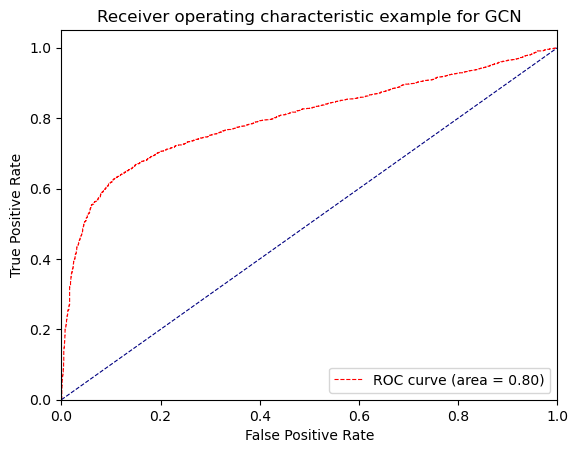

In [22]:
predictions = []
probabilities = []
truths = []

# Loadder names: train_loader, test_loader, all_loader
model.eval()
with torch.no_grad():
    for data in tqdm(train_loader): 
        
        # Grab inputs
        X, Y, EI  = data.x, data.y, data.edge_index
        B = data.batch

        # Compute preds
        logits = model(X, EI, B).flatten()
        acc, pred, probas = binary_acc(logits, Y)

        # Append data
        predictions.append(pred)
        probabilities.append(probas)
        truths.append(Y)

# Format
p = np.hstack(predictions)
t = np.hstack(truths)
prob = np.array(torch.concat(probabilities))

# AUC/ROC
fpr, tpr, _ = roc_curve(t, prob)
roc_auc = auc(fpr, tpr)

# Plotting
plt.figure()
lw = 0.8
plt.plot(fpr, tpr, "r--", lw=lw, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example for GCN")
plt.legend(loc="lower right")
plt.show()
plt.show()
